In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
%matplotlib inline
import statsmodels.api as sm
from datetime import timedelta,datetime

# read train, test data, and state table

In [2]:
# read training data and transition matrix
df=pd.read_csv("SH_SDS_data_Dec2_4.csv",index_col=0)
prob=pd.read_csv("SH_SDS_transition_matrix_Dec2.csv",index_col=0)
df.index = pd.to_datetime(df.index,utc=True)

In [4]:
# rebuild the index of transition matrix
rows=[]
for price_relation_d in range(6):
    for s1_imb_d in range(3):
        for s2_imb_d in range(3):
            s1_imb_d, s2_imb_d, price_relation_d = str(s1_imb_d),str(s2_imb_d),str(price_relation_d)
            rows.append(price_relation_d+s1_imb_d+s2_imb_d)
prob.index=rows

In [6]:
markov_adj=pd.read_csv('Markov_exp_move_Dec2.csv',index_col=0)
markov_adj.index=rows

In [8]:
state_table=markov_adj
df.current_state=df.current_state.astype('str')
for i in range(len(df)):
    state=df.current_state.iloc[i]
    if len(state)<3:
        df.current_state.iloc[i]='0'+state
state_table=state_table.assign(freq=state_table.index.map(df.current_state.value_counts())).fillna(0)

C:\Users\Anne Shen\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [10]:
# read testing data and transition matrix
df_test=pd.read_csv("SH_SDS_data_Dec3.csv",index_col=0)
df_test.drop(index=[0],inplace=True)  # remove the first row because the time interval btw row 0 and 1 is not 10 seconds
df_test.reset_index(drop=True,inplace=True)

# in-sample parameters calculation and test data preparation

In [11]:
def calculate_train_parameters(df, res_num, imb1_num, imb2_num):
    # calculate in-sample beta, constant, and symmetrize data and cut states
    X = sm.add_constant(df.mid2)
    res = sm.OLS(df.mid1, X).fit()
    constant=res.params[0]
    slope=res.params[1]
    
    df['residual_bucket'], res_bins = pd.cut(df['residuals'], res_num, labels=False, retbins=True)
    df['imb1_bucket'], imb1_bins = pd.cut(df.imb1, imb1_num, labels=False, retbins=True)
    df['imb2_bucket'], imb2_bins = pd.cut(df.imb2, imb2_num, labels=False, retbins=True)
    
    return slope, constant, res_bins, imb1_bins, imb2_bins

In [12]:
res_num=6
imb1_num=3
imb2_num=3
slope, constant, res_bins, imb1_bins, imb2_bins=calculate_train_parameters(df, res_num, imb1_num, imb2_num)

In [14]:
def change_bins_end_boundaries(bins):
    # change the left and right most boundaries in order to use the bins on test data
    bins[0]=-10
    bins[-1]=10

change_bins_end_boundaries(res_bins)
change_bins_end_boundaries(imb1_bins)
change_bins_end_boundaries(imb2_bins)

In [15]:
def prep_test_data(df, slope, constant, res_bins, imb1_bins, imb2_bins):
    # symmetrize test data, cut states based on the training parameters and construct states
    df['mid1']=(df.bid1+df.ask1)/2
    df['mid2']=(df.bid2+df.ask2)/2
    
    predicted_Y=constant+slope*df.mid2
    df['residuals']=df.mid1-predicted_Y
    
    df_flip=df.copy()
    df_flip.columns=['time', 'ask1', 'ask_size1', 'bid1', 'bid_size1', 'ask2', 'ask_size2', 'bid2', 'bid_size2',
                     'mid1','mid2','residuals']
    df_flip[['ask1', 'bid1', 'ask2', 'bid2','residuals']]=-df_flip[['ask1', 'bid1', 'ask2', 'bid2','residuals']]

    change1=df.bid1[len(df)-1]-df_flip.bid1[0]-0.01
    change2=df.bid2[len(df)-1]-df_flip.bid2[0]-0.01

    df_flip[['ask1', 'bid1']]=df_flip[['ask1', 'bid1']]+change1
    df_flip[['ask2', 'bid2']]=df_flip[['ask2', 'bid2']]+change2
    
    df_flip['mid1']=(df_flip.bid1+df_flip.ask1)/2
    df_flip['mid2']=(df_flip.bid2+df_flip.ask2)/2
    predicted_Y_flip=constant+slope*df_flip.mid2

    df_flip.time=pd.to_datetime(df_flip.time)
    df_flip.time+=timedelta(hours=6)
    
    df.set_index("time",inplace=True)
    df.index = pd.to_datetime(df.index,utc=True)
    df['imb1']=df.bid_size1/(df.bid_size1+df.ask_size1)
    df['imb2']=df.bid_size2/(df.bid_size2+df.ask_size2)
    df2=df[['residuals','mid1','mid2','imb1','imb2']]
    df2.index = df.index.shift(-10,freq='S')
    df2.columns=['residual_later','mid1_later','mid2_later','imb1_later','imb2_later']
    df = pd.merge_asof(df, df2, left_index=True, right_index=True, direction='forward')
    df['pnl'] = df.residual_later-df.residuals  # forward pnl
    df['mid1_diff'] = df.mid1_later-df.mid1
    df['mid2_diff'] = df.mid2_later-df.mid2
    df.dropna(inplace=True)
    
    df_flip.set_index("time",inplace=True)
    df_flip.index = pd.to_datetime(df_flip.index,utc=True)
    df_flip['imb1']=df_flip.bid_size1/(df_flip.bid_size1+df_flip.ask_size1)
    df_flip['imb2']=df_flip.bid_size2/(df_flip.bid_size2+df_flip.ask_size2)
    df2_flip=df_flip[['residuals','mid1','mid2','imb1','imb2']]
    df2_flip.index = df_flip.index.shift(-10,freq='S')# - timedelta(minutes=5)  # data from 5 minutes later
    df2_flip.columns=['residual_later','mid1_later','mid2_later','imb1_later','imb2_later']
    df_flip = pd.merge_asof(df_flip, df2_flip, left_index=True, right_index=True, direction='forward')
    df_flip['pnl'] = df_flip.residual_later-df_flip.residuals  # forward pnl
    df_flip['mid1_diff'] = df_flip.mid1_later-df_flip.mid1
    df_flip['mid2_diff'] = df_flip.mid2_later-df_flip.mid2
    df_flip.dropna(inplace=True)
    
    df=pd.concat([df,df_flip])

    df.index = pd.to_datetime(df.index,utc=True)
    
    df['residual_bucket'] = pd.cut(df['residuals'], res_bins, labels=False)
    
    df['imb1']=df.bid_size1/(df.bid_size1+df.ask_size1)
    df['imb2']=df.bid_size2/(df.bid_size2+df.ask_size2)
    df['imb1_bucket'] = pd.cut(df.imb1, imb1_bins, labels=False)
    df['imb2_bucket'] = pd.cut(df.imb2, imb2_bins, labels=False)
    
    df['dM1']=1*(df.mid1_diff>0)
    df.dM1-=1*(df.mid1_diff<0)
    df['dM2']=1*(df.mid2_diff>0)
    df.dM2-=1*(df.mid2_diff<0)

    df['residual_bucket_later'] = pd.cut(df['residual_later'], res_bins, labels=False)
    df['imb1_bucket_later'] = pd.cut(df['imb1_later'], imb1_bins, labels=False)
    df['imb2_bucket_later'] = pd.cut(df['imb2_later'], imb2_bins, labels=False)
    
    df['current_state']=df["residual_bucket"].astype(str) + df["imb1_bucket"].astype(str) + df["imb2_bucket"].astype(str)
    df['later_state']=df["residual_bucket_later"].astype(str)+df["imb1_bucket_later"].astype(str)+df["imb2_bucket_later"].astype(str)+df.dM1.astype(str)+df.dM2.astype(str)
    
    x=df.dM1.astype(str)+df.dM2.astype(str)
    df.drop(index=df.index[np.where((x=='-1-1')|(x=='11'))],inplace=True)
    return df

In [16]:
df_test=prep_test_data(df_test, slope, constant, res_bins, imb1_bins, imb2_bins)

In [17]:
df_test.current_state=df_test.current_state.astype('str')
for i in range(len(df_test)):
    state=df_test.current_state.iloc[i]
    if len(state)<3:
        df_test.current_state.iloc[i]='0'+state

# Random algo
At the beginning of each 5 minutes, buy or sell \\$1000 SH or \\$500 SDS

In [18]:
class buyer:
    
    def __init__(self, cash,pnl, inventory1,inventory2,price1,price2):
        self.cash = cash
        self.inventory1 = inventory1
        self.inventory2 = inventory2
        self.price1=price1
        self.price2=price2
        self.pnl=pnl
        self.pnl_list=[]
        self.inventory1_list=[]
        self.inventory2_list=[]
        self.price1_list=[]
        self.price2_list=[]
        self.tick = 0.01
        
    def get_pnl(self):
        return self.pnl_list
    
    def get_inventory(self):
        return self.inventory1_list, self.inventory2_list
        
    def trade_SH(self,price1,price2):
        self.price1=price1
        self.price2=price2
        self.price1_list.append(self.price1)
        self.inventory1=self.inventory1+1000/(self.price1+self.tick/2)  #buy SH
        self.cash=self.cash-1000
        
    def trade_SDS(self,price1,price2):
        self.price1=price1
        self.price2=price2
        self.price2_list.append(self.price2)
        self.inventory2=self.inventory2+500/(self.price2+self.tick/2)  #buy SDS
        self.cash=self.cash-500
        
    def check_buy_SH_or_SDS(self,state,inventory1,inventory2,price1,price2):
        if state=='SDS':
            self.trade_SDS(price1,price2)
            self.pnl=self.cash+self.inventory1*(price1)+self.inventory2*(price2)
        elif state=='SH':
            self.trade_SH(price1,price2)
            self.pnl=self.cash+self.inventory1*(price1)+self.inventory2*(price2)
        else:
            self.inventory1=inventory1
            self.inventory2=inventory2
            
        self.pnl_list.append(self.pnl)
        self.inventory1_list.append(self.inventory1)
        self.inventory2_list.append(self.inventory2)
        return self.inventory1, self.inventory2, self.price1_list, self.price2_list

In [19]:
class seller:
    
    def __init__(self,cash,pnl,inventory1,inventory2,price1,price2):
        self.cash = cash
        self.inventory1 = inventory1
        self.inventory2 = inventory2
        self.price1=price1
        self.price2=price2
        self.pnl=pnl
        self.pnl_list=[]
        self.inventory1_list=[]
        self.inventory2_list=[]
        self.price1_list=[]
        self.price2_list=[]
        self.tick = 0.01
        
    def get_pnl(self):
        return self.pnl_list
    
    def get_inventory(self):
        return self.inventory1_list, self.inventory2_list
        
    def trade_SH(self,price1,price2):
        self.price1=price1
        self.price2=price2
        self.price1_list.append(self.price1)
        self.inventory1=self.inventory1-1000/(self.price1-self.tick/2)  #sell SH
        self.cash=self.cash+1000
        
    def trade_SDS(self,price1,price2):
        self.price1=price1
        self.price2=price2
        self.price2_list.append(self.price2)
        self.inventory2=self.inventory2-500/(self.price2-self.tick/2)  #sell SDS
        self.cash=self.cash+500
        
    def check_sell_SH_or_SDS(self,state,inventory1,inventory2,price1,price2):
        if state=='SDS':
            self.trade_SDS(price1,price2)
#             self.cost+=self.inventory2*(price2+self.tick/2)
            self.pnl=self.cash+self.inventory1*(price1)+self.inventory2*(price2)
        elif state=='SH':
            self.trade_SH(price1,price2)
#             self.cost+=self.inventory1*(price1+self.tick/2)
            self.pnl=self.cash+self.inventory1*(price1)+self.inventory2*(price2)
        else:
            self.inventory1=inventory1
            self.inventory2=inventory2
        
        self.pnl_list.append(self.pnl)
        self.inventory1_list.append(self.inventory1)
        self.inventory2_list.append(self.inventory2)
        
        return self.inventory1, self.inventory2, self.price1_list, self.price2_list

In [76]:
# random algo
def random_algo(df,buy_or_sell='s'):
    # buy_or_sell: 'b' -- buy, else sell
    tick = 0.01
    cash=0
    pnl=0
    inventory1=0
    inventory2=0
    
    df_random=df[~df.index.duplicated(keep='first')].resample('5T').first()
    np.random.seed(123)
    df_random['random_which_asset']=np.random.choice(['SH','SDS'],size=len(df_random))
    
    if buy_or_sell=='b':
        t1=buyer(cash,pnl,inventory1,inventory2,df_random.mid1[0],df_random.mid2[0])
        for i in range(len(df_random)):
            inventory1, inventory2,price1_list,price2_list=t1.check_buy_SH_or_SDS(df_random.random_which_asset[i],inventory1,inventory2,df_random.mid1[i],df_random.mid2[i])
        print('Random algo buys',inventory1,'shares of SH and',inventory2,'shares of SDS for a total used cash $', -t1.cash, 'and total pnl $', t1.pnl)

    else:
        t1=seller(cash,pnl,inventory1,inventory2,df_random.mid1[0],df_random.mid2[0])
        for i in range(len(df_random)):
            inventory1, inventory2,price1_list,price2_list=t1.check_sell_SH_or_SDS(df_random.random_which_asset[i],inventory1,inventory2,df_random.mid1[i],df_random.mid2[i])
        print('Random algo sells',-inventory1,'shares of SH and',-inventory2,'shares of SDS for a total used cash $', t1.cash, 'and total pnl $', t1.pnl)

    # average trade price for SH
    price1=np.mean(price1_list)
    # average trade price for SDS
    price2=np.mean(price2_list)
    print('Average trade price for SH is $',price1)
    print('Average trade price for SDS is $',price2)
    print('Sum of Avg_price * inventory for SH+SDS is $',price1*inventory1+price2*inventory2)
    
    results.append([buy_or_sell,'1. random algo',price1,inventory1,price2,inventory2,t1.pnl])
    
    plt.plot(t1.get_pnl())
    
    return df_random

# Weighted-mid-vs-mid Algo
At the beginning of each 5 minutes, buy or sell \\$1000 SH or \\$500 SDS based on weighted mid minus mid

In [77]:
# Average shares of each asset at one execution
SH_shares=1000/np.mean(df.mid1)
SDS_shares=500/np.mean(df.mid2)

In [78]:
# weighted-mid algo
def weighted_mid_algo(df,buy_or_sell='s'):
    # buy_or_sell: 'b' -- buy, else sell
    tick = 0.01
    cash=0
    pnl=0
    inventory1=0
    inventory2=0
    
    df_weighted=df[~df.index.duplicated(keep='first')].resample('5T').first()
    df_weighted['weighted_mid1']=(df_weighted.ask1 * df_weighted.bid_size1 + df_weighted.bid1 * df_weighted.ask_size1) / (df_weighted.ask_size1 + df_weighted.bid_size1)
    df_weighted['weighted_mid2']=(df_weighted.ask2 * df_weighted.bid_size2 + df_weighted.bid2 * df_weighted.ask_size2) / (df_weighted.ask_size2 + df_weighted.bid_size2)
    
    if buy_or_sell == 'b':
        df_weighted.loc[SH_shares*(df_weighted.weighted_mid1-df_weighted.mid1) >= SDS_shares*(df_weighted.weighted_mid2-df_weighted.mid2), 'weighted_which_asset']='SH'
        df_weighted.loc[SH_shares*(df_weighted.weighted_mid1-df_weighted.mid1) < SDS_shares*(df_weighted.weighted_mid2-df_weighted.mid2), 'weighted_which_asset']='SDS'
    else:
        df_weighted.loc[SH_shares*(df_weighted.weighted_mid1-df_weighted.mid1) >= SDS_shares*(df_weighted.weighted_mid2-df_weighted.mid2), 'weighted_which_asset']='SDS'
        df_weighted.loc[SH_shares*(df_weighted.weighted_mid1-df_weighted.mid1) < SDS_shares*(df_weighted.weighted_mid2-df_weighted.mid2), 'weighted_which_asset']='SH'
    
    if buy_or_sell=='b':
        t1=buyer(cash,pnl,inventory1,inventory2,df_weighted.mid1[0],df_weighted.mid2[0])
        for i in range(len(df_weighted)):
            inventory1, inventory2,price1_list,price2_list=t1.check_buy_SH_or_SDS(df_weighted.weighted_which_asset[i],inventory1,inventory2,df_weighted.mid1[i],df_weighted.mid2[i])
        print('Weighted_mid algo buys',inventory1,'shares of SH and',inventory2,'shares of SDS for a total used cash $', -t1.cash, 'and total pnl $', t1.pnl)

    else:
        t1=seller(cash,pnl,inventory1,inventory2,df_weighted.mid1[0],df_weighted.mid2[0])
        for i in range(len(df_weighted)):
            inventory1, inventory2,price1_list,price2_list=t1.check_sell_SH_or_SDS(df_weighted.weighted_which_asset[i],inventory1,inventory2,df_weighted.mid1[i],df_weighted.mid2[i])
        print('Weighted_mid algo sells',-inventory1,'shares of SH and',-inventory2,'shares of SDS for a total used cash $', t1.cash, 'and total pnl $', t1.pnl)

    # average trade price for SH
    price1=np.mean(price1_list)
    # average trade price for SDS
    price2=np.mean(price2_list)
    print('Average trade price for SH is $',price1)
    print('Average trade price for SDS is $',price2)
    print('Sum of Avg_price * inventory for SH+SDS is $',price1*inventory1+price2*inventory2)
    
    results.append([buy_or_sell,'2. weighted mid algo',price1,inventory1,price2,inventory2,t1.pnl])
    
    plt.plot(t1.get_pnl())
    
    return df_weighted

# Execute at the beginnning based on micro price
At the beginning of each 5 minutes, buy or sell \$1000 SH or \\$500 SDS based on micro price adjustment

In [79]:
# trade at the beginning of every 5 minute, based on micro price
def micro_algo(df,state_table,buy_or_sell='s'):
    # buy_or_sell: 'b' -- buy, else sell
    tick = 0.01
    cash=0
    pnl=0
    inventory1=0
    inventory2=0
#     x=state_table.rename_axis('current_state').reset_index()
#     df=df.join(x,on='current_state')
    
    df_micro=df.assign(price1_change_5step=df.current_state.map(state_table.price1_change_5step),price2_change_5step=df.current_state.map(state_table.price2_change_5step))
    df_micro=df_micro[~df.index.duplicated(keep='first')].resample('5T').first()
    
    if buy_or_sell == 'b':
        df_micro.loc[SH_shares*(df_micro.price1_change_5step) >= SDS_shares*(df_micro.price2_change_5step), 'micro_which_asset']='SH'
        df_micro.loc[SH_shares*(df_micro.price1_change_5step) < SDS_shares*(df_micro.price2_change_5step), 'micro_which_asset']='SDS'
    else:
        df_micro.loc[SH_shares*(df_micro.price1_change_5step) >= SDS_shares*(df_micro.price2_change_5step), 'micro_which_asset']='SDS'
        df_micro.loc[SH_shares*(df_micro.price1_change_5step) < SDS_shares*(df_micro.price2_change_5step), 'micro_which_asset']='SH'
        
        
    if buy_or_sell=='b':
        t1=buyer(cash,pnl,inventory1,inventory2,df_micro.mid1[0],df_micro.mid2[0])
        for i in range(len(df_micro)):
            inventory1, inventory2,price1_list,price2_list=t1.check_buy_SH_or_SDS(df_micro.micro_which_asset[i],inventory1,inventory2,df_micro.mid1[i],df_micro.mid2[i])
        print('Micro algo buys',inventory1,'shares of SH and',inventory2,'shares of SDS for a total used cash $', -t1.cash, 'and total pnl $', t1.pnl)

    else:
        t1=seller(cash,pnl,inventory1,inventory2,df_micro.mid1[0],df_micro.mid2[0])
        for i in range(len(df_micro)):
            inventory1, inventory2,price1_list,price2_list=t1.check_sell_SH_or_SDS(df_micro.micro_which_asset[i],inventory1,inventory2,df_micro.mid1[i],df_micro.mid2[i])
        print('Micro algo sells',-inventory1,'shares of SH and',-inventory2,'shares of SDS for a total used cash $', t1.cash, 'and total pnl $', t1.pnl)

    
    # average trade price for SH
    price1=np.mean(price1_list)
    # average trade price for SDS
    price2=np.mean(price2_list)
    print('Average trade price for SH is $',price1)
    print('Average trade price for SDS is $',price2)
    print('Sum of Avg_price * inventory for SH+SDS is $',price1*inventory1+price2*inventory2)
    
    results.append([buy_or_sell,'3. micro algo',price1,inventory1,price2,inventory2,t1.pnl])
    
    plt.plot(t1.get_pnl())
    
    return df_micro

# Amrican Sniper Algo using abs diff with constant threshold
Inside each 5 minutes, buy or sell \\$1000 SH or \\$500 SDS based on a threshold

In [24]:
# cut the absolute difference btw two adjustments into 30 buckets
state_table['30cuts_allocation_absDiff']=pd.cut((SH_shares*state_table.price1_change_5step-SDS_shares*state_table.price2_change_5step).abs(),bins=30,labels=False)

In [80]:
# American snipper algo using absolute difference of adjustments with 
def american_sniper_algo_absDiff_constant(df,state_table,threshold,traded_limit,buy_or_sell='s'):
    # buy_or_sell: 'b' -- buy, else sell
    # threshold: an integer or a list of thresholds
    # traded_limit: length of the 5-min-resampled data frame in previous algos
    tick = 0.01
    cash=0
    pnl=0
    inventory1=0
    inventory2=0
    num_traded=0
    traded_time=[]
    
    df['which_asset']='0'
    df['theshold_bucket']=threshold # or use [29-i%30 for i in range(len(df))] as a decreasing-over-time threshold
    df=df.join(state_table,'current_state')
    traded=False
    
    index_5_min=df[~df.index.duplicated(keep='first')].resample("5T").first().index
    df_every_5_min=pd.DataFrame([1]*len(index_5_min),index=index_5_min,columns=['5_min_start'])
    df['real_time']=df.index
    trade_period=pd.merge_asof(df_every_5_min, df.real_time.sort_index(), left_index=True, right_index=True, direction="forward")
    df2=df[~df.index.duplicated(keep='first')].merge(trade_period.set_index('real_time'),'left',left_index=True,right_index=True).fillna(0)
    
    
    if buy_or_sell=='b':
        if (df2.iloc[0]['theshold_bucket']<=df2.iloc[0]['30cuts_allocation_absDiff']) & (traded==False):
            if SH_shares*df2.iloc[0].price1_change_5step >= SDS_shares*df2.iloc[0].price2_change_5step:
                df2.which_asset.iloc[0]='SH'
            else:
                df2.which_asset.iloc[0]='SDS'
            traded=True
            num_traded+=1
            traded_time.append('early')
        for i in range(1,len(df2)):
            if (df2['5_min_start'].iloc[i]!=1) & (df2.iloc[i-1]['theshold_bucket']<=df2.iloc[i-1]['30cuts_allocation_absDiff']) & (traded==False):
                if SH_shares*df2.iloc[i-1].price1_change_5step >= SDS_shares*df2.iloc[i-1].price2_change_5step:
                    df2.which_asset.iloc[i-1]='SH'
                else:
                    df2.which_asset.iloc[i-1]='SDS'
                traded=True
                num_traded+=1
                traded_time.append('early')
                
            if df2['5_min_start'].iloc[i]==1:
                if traded==False:
                    if SH_shares*df2.iloc[i-1].price1_change_5step >= SDS_shares*df2.iloc[i-1].price2_change_5step:
                        df2.which_asset.iloc[i-1]='SH'
                    else:
                        df2.which_asset.iloc[i-1]='SDS'
                    num_traded+=1
                    traded_time.append('end_of_5_min')
                else:
                    traded=False
                    
            if num_traded==traded_limit:
                break
        
        df_trade=df2[df2.which_asset!='0']
        t1=buyer(cash,pnl,inventory1,inventory2,df_trade.mid1[0],df_trade.mid2[0])
        for i in range(len(df_trade)):
            inventory1, inventory2,price1_list,price2_list=t1.check_buy_SH_or_SDS(df_trade.which_asset[i],inventory1,inventory2,df_trade.mid1[i],df_trade.mid2[i])
        print('American snipper algo (abs diff) buys',inventory1,'shares of SH and',inventory2,
              'shares of SDS for a total used cash $', -t1.cash, 'and total pnl $', t1.pnl)

    else:
        if (df2.iloc[0]['theshold_bucket']<=df2.iloc[0]['30cuts_allocation_absDiff']) & (traded==False):
            if SH_shares*df2.iloc[0].price1_change_5step <= SDS_shares*df2.iloc[0].price2_change_5step:
                df2.which_asset.iloc[0]='SH'
            else:
                df2.which_asset.iloc[0]='SDS'
            traded=True
            num_traded+=1
            traded_time.append('early')
        for i in range(1,len(df2)-1):
            if (df2['5_min_start'].iloc[i]!=1) & (df2.iloc[i-1]['theshold_bucket']<=df2.iloc[i-1]['30cuts_allocation_absDiff']) & (traded==False):
                if SH_shares*df2.iloc[i-1].price1_change_5step <= SDS_shares*df2.iloc[i-1].price2_change_5step:
                    df2.which_asset.iloc[i-1]='SH'
                else:
                    df2.which_asset.iloc[i-1]='SDS'
                traded=True
                num_traded+=1
                traded_time.append('early')
                
            if df2['5_min_start'].iloc[i]==1:
                if traded==False:
                    if SH_shares*df2.iloc[i-1].price1_change_5step <= SDS_shares*df2.iloc[i-1].price2_change_5step:
                        df2.which_asset.iloc[i-1]='SH'
                    else:
                        df2.which_asset.iloc[i-1]='SDS'
                    num_traded+=1
                    traded_time.append('end_of_5_min')
                else:
                    traded=False
                    
            if num_traded==traded_limit:
                break
        df_trade=df2[df2.which_asset!='0']
        t1=seller(cash,pnl,inventory1,inventory2,df_trade.mid1[0],df_trade.mid2[0])
        for i in range(len(df_trade)):
            inventory1, inventory2,price1_list,price2_list=t1.check_sell_SH_or_SDS(df_trade.which_asset[i],inventory1,inventory2,df_trade.mid1[i],df_trade.mid2[i])
        print('American snipper algo (abs diff) sells',-inventory1,'shares of SH and',-inventory2,
              'shares of SDS for a total used cash $', t1.cash, 'and total pnl $', t1.pnl)
#               sum(a*(b+tick/2) + c*(d+tick/2) for a,b,c,d in zip(inventory1, price1_list, inventory2, price2_list)))

    # average trade price for SH
    price1=np.mean(price1_list)
    # average trade price for SDS
    price2=np.mean(price2_list)
    print('Average trade price for SH is $',price1)
    print('Average trade price for SDS is $',price2)
    print('Sum of Avg_price * inventory for SH+SDS is $',price1*inventory1+price2*inventory2)
    
    results.append([buy_or_sell,'4. American sniper algo_'+str(threshold).zfill(2),price1,inventory1,price2,inventory2,t1.pnl])
    
    plt.plot(t1.get_pnl())
    
    return traded_time

## Buy \\$1000 SH or \\$500 SDS

In [81]:
results=[]

Random algo buys 3623.3005583510053 shares of SH and 2513.8172912651253 shares of SDS for a total used cash $ 100000 and total pnl $ 302.55683436658
Average trade price for SH is $ 18.48649253731344
Average trade price for SDS is $ 13.122575757575758
Sum of Avg_price * inventory for SH+SDS is $ 99969.87657772996


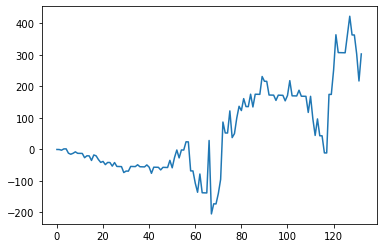

In [82]:
df_random = random_algo(df,'b')

Random algo buys 3968.0150643150696 shares of SH and 2772.9443541913324 shares of SDS for a total used cash $ 109000 and total pnl $ 228.27777334729035
Average trade price for SH is $ 18.392123287671236
Average trade price for SDS is $ 12.977638888888887
Sum of Avg_price * inventory for SH+SDS is $ 108966.4927578978


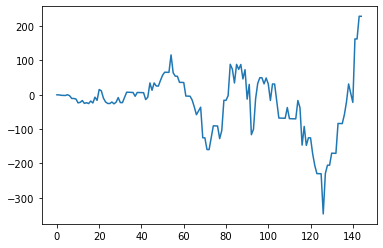

In [83]:
df_random_test=random_algo(df_test,'b')

Weighted_mid algo buys 3514.196244018175 shares of SH and 2591.6966698564925 shares of SDS for a total used cash $ 99000 and total pnl $ 307.1479749347418
Average trade price for SH is $ 18.491461538461543
Average trade price for SDS is $ 13.113970588235293
Sum of Avg_price * inventory for SH+SDS is $ 98970.05858699349


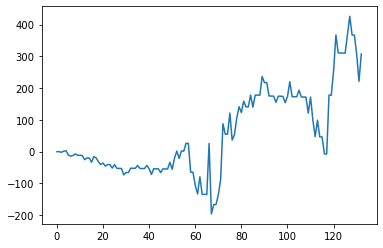

In [84]:
df_weighted=weighted_mid_algo(df,'b')

Weighted_mid algo buys 3914.406062361116 shares of SH and 2811.346997916066 shares of SDS for a total used cash $ 108500 and total pnl $ 240.72634686034144
Average trade price for SH is $ 18.388611111111118
Average trade price for SDS is $ 12.978150684931506
Sum of Avg_price * inventory for SH+SDS is $ 108466.57577831886


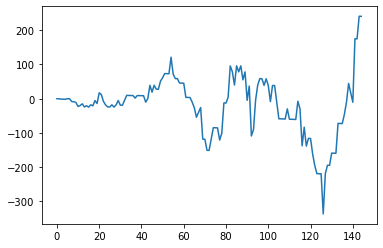

In [85]:
df_weighted_test=weighted_mid_algo(df_test,'b')

Micro algo buys 3571.3210063402375 shares of SH and 2549.667130546856 shares of SDS for a total used cash $ 99500 and total pnl $ 311.7959687766197
Average trade price for SH is $ 18.47560606060606
Average trade price for SDS is $ 13.134104477611942
Sum of Avg_price * inventory for SH+SDS is $ 99469.91450484487


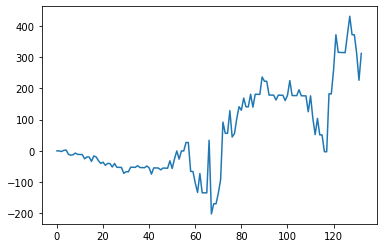

In [86]:
df_micro=micro_algo(df,state_table,'b')

Micro algo buys 3913.7854500269887 shares of SH and 2812.3255920984093 shares of SDS for a total used cash $ 108500 and total pnl $ 242.0377538290777
Average trade price for SH is $ 18.39152777777778
Average trade price for SDS is $ 12.9736301369863
Sum of Avg_price * inventory for SH+SDS is $ 108466.56587709964


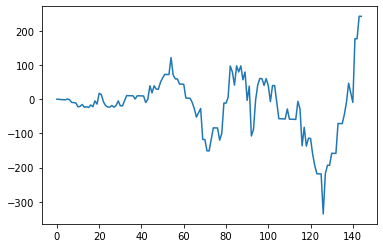

In [87]:
df_micro_test=micro_algo(df_test,state_table,'b')

## Find the states where different executions between weighted-mid algo and micro algo happen

In [88]:
traded_asset=pd.concat([df_random.random_which_asset,df_weighted.weighted_which_asset,df_micro.micro_which_asset,df_micro.current_state],axis=1)
traded_asset

,random_which_asset,weighted_which_asset,micro_which_asset,current_state
time,,,,
2020-12-02 14:45:00+00:00,SH,SDS,SDS,412
2020-12-02 14:50:00+00:00,SDS,SDS,SDS,411
2020-12-02 14:55:00+00:00,SH,SH,SH,210
2020-12-02 15:00:00+00:00,SH,SDS,SDS,512
2020-12-02 15:05:00+00:00,SH,SH,SDS,311
...,...,...,...,...
2020-12-03 01:25:00+00:00,SH,SDS,SDS,311
2020-12-03 01:30:00+00:00,SDS,SH,SDS,311
2020-12-03 01:35:00+00:00,SDS,SDS,SH,200


In [89]:
traded_asset[traded_asset.weighted_which_asset!=traded_asset.micro_which_asset]

,random_which_asset,weighted_which_asset,micro_which_asset,current_state
time,,,,
2020-12-02 15:05:00+00:00,SH,SH,SDS,311
2020-12-02 15:30:00+00:00,SH,SDS,SH,211
2020-12-02 15:35:00+00:00,SDS,SDS,SH,211
2020-12-02 15:45:00+00:00,SH,SDS,SH,212
2020-12-02 16:55:00+00:00,SDS,SDS,SH,200
2020-12-02 17:00:00+00:00,SH,SDS,SH,211
2020-12-02 17:05:00+00:00,SH,SDS,SH,201
2020-12-02 17:20:00+00:00,SDS,SDS,SH,211
2020-12-02 17:25:00+00:00,SDS,SDS,SH,211


In [90]:
traded_asset_test=pd.concat([df_random_test.random_which_asset,df_weighted_test.weighted_which_asset,df_micro_test.micro_which_asset,df_micro_test.current_state],axis=1)
traded_asset_test[traded_asset_test.weighted_which_asset!=traded_asset_test.micro_which_asset]

,random_which_asset,weighted_which_asset,micro_which_asset,current_state
time,,,,
2020-12-03 14:55:00+00:00,SH,SDS,SH,212
2020-12-03 15:00:00+00:00,SH,SDS,SH,211
2020-12-03 15:05:00+00:00,SH,SDS,SH,211
2020-12-03 15:45:00+00:00,SH,SDS,SH,212
2020-12-03 16:15:00+00:00,SDS,SH,SDS,300
2020-12-03 16:25:00+00:00,SH,SDS,SH,211
2020-12-03 18:15:00+00:00,SH,SH,SDS,311
2020-12-03 18:25:00+00:00,SDS,SDS,SH,211
2020-12-03 20:40:00+00:00,SDS,SH,SDS,311


In [91]:
traded_asset_test[traded_asset_test.weighted_which_asset!=traded_asset_test.micro_which_asset].current_state.value_counts()

311    6
211    6
212    2
310    2
222    1
300    1
Name: current_state, dtype: int64

C:\Users\Anne Shen\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


American snipper algo (abs diff) buys 3571.3210063402375 shares of SH and 2549.667130546856 shares of SDS for a total used cash $ 99500 and total pnl $ 311.7959687766197
Average trade price for SH is $ 18.475606060606065
Average trade price for SDS is $ 13.134104477611942
Sum of Avg_price * inventory for SH+SDS is $ 99469.9145048449
American snipper algo (abs diff) buys 3913.7854500269887 shares of SH and 2812.3255920984093 shares of SDS for a total used cash $ 108500 and total pnl $ 242.0377538290777
Average trade price for SH is $ 18.39152777777778
Average trade price for SDS is $ 12.9736301369863
Sum of Avg_price * inventory for SH+SDS is $ 108466.56587709964
American snipper algo (abs diff) buys 3571.3210063402375 shares of SH and 2549.667130546856 shares of SDS for a total used cash $ 99500 and total pnl $ 311.7959687766197
Average trade price for SH is $ 18.475606060606065
Average trade price for SDS is $ 13.134104477611942
Sum of Avg_price * inventory for SH+SDS is $ 99469.91450

American snipper algo (abs diff) buys 3913.903404982485 shares of SH and 2812.769908891178 shares of SDS for a total used cash $ 108500 and total pnl $ 154.60386788225878
Average trade price for SH is $ 18.390972222222224
Average trade price for SDS is $ 12.971575342465751
Sum of Avg_price * inventory for SH+SDS is $ 108466.54559569631
American snipper algo (abs diff) buys 3408.076856124192 shares of SH and 2666.231560713109 shares of SDS for a total used cash $ 98000 and total pnl $ 296.3053406571271
Average trade price for SH is $ 18.480555555555565
Average trade price for SDS is $ 13.122285714285711
Sum of Avg_price * inventory for SH+SDS is $ 97970.20599732961
American snipper algo (abs diff) buys 3913.903404982485 shares of SH and 2812.769908891178 shares of SDS for a total used cash $ 108500 and total pnl $ 154.60386788225878
Average trade price for SH is $ 18.390972222222224
Average trade price for SDS is $ 12.971575342465751
Sum of Avg_price * inventory for SH+SDS is $ 108466.5

American snipper algo (abs diff) buys 3625.8738128703226 shares of SH and 2474.0828066160934 shares of SDS for a total used cash $ 99500 and total pnl $ 240.61253252361348
Average trade price for SH is $ 18.47335820895523
Average trade price for SDS is $ 13.13130769230769
Sum of Avg_price * inventory for SH+SDS is $ 99470.00835554788
American snipper algo (abs diff) buys 3913.608100906612 shares of SH and 2774.427803678157 shares of SDS for a total used cash $ 108000 and total pnl $ 245.15140211234393
Average trade price for SH is $ 18.392361111111118
Average trade price for SDS is $ 12.970694444444442
Sum of Avg_price * inventory for SH+SDS is $ 107966.74873892468
American snipper algo (abs diff) buys 3625.8738128703226 shares of SH and 2474.0828066160934 shares of SDS for a total used cash $ 99500 and total pnl $ 240.61253252361348
Average trade price for SH is $ 18.47335820895523
Average trade price for SDS is $ 13.13130769230769
Sum of Avg_price * inventory for SH+SDS is $ 99470.00

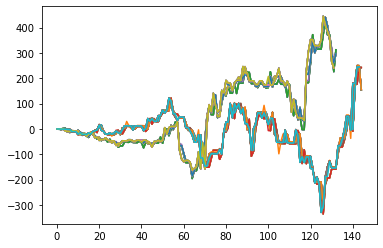

In [92]:
# American Sniper with different thresholds
traded_time_train_buy=[]
traded_time_test_buy=[]
for i in range(30):
    traded_time_train_buy.append(american_sniper_algo_absDiff_constant(df,state_table,i,len(df_micro),buy_or_sell='b'))
    traded_time_test_buy.append(american_sniper_algo_absDiff_constant(df_test,state_table,i,len(df_micro_test),buy_or_sell='b'))

## Sell \\$1000 SH or \\$500 SDS

Random algo sells 3625.2610742627176 shares of SH and 2515.733702665494 shares of SDS for a total used cash $ 100000 and total pnl $ -364.1628811040209
Average trade price for SH is $ 18.48649253731344
Average trade price for SDS is $ 13.122575757575758
Sum of Avg_price * inventory for SH+SDS is $ -100031.26789428515


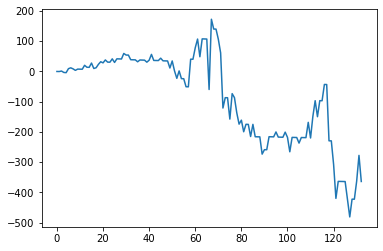

In [93]:
df_random_sell = random_algo(df,'s')

Random algo sells 3970.1731081734574 shares of SH and 2775.0819032489044 shares of SDS for a total used cash $ 109000 and total pnl $ -295.88130791296135
Average trade price for SH is $ 18.392123287671236
Average trade price for SDS is $ 12.977638888888887
Sum of Avg_price * inventory for SH+SDS is $ -109033.9241063779


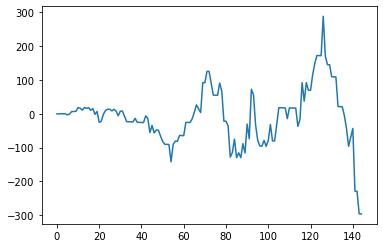

In [94]:
df_random_test_sell = random_algo(df_test,'s')

Weighted_mid algo sells 3679.548396988453 shares of SH and 2476.9283732888284 shares of SDS for a total used cash $ 100500 and total pnl $ -358.7301399941971
Average trade price for SH is $ 18.485588235294124
Average trade price for SDS is $ 13.126230769230768
Sum of Avg_price * inventory for SH+SDS is $ -100531.34998520964


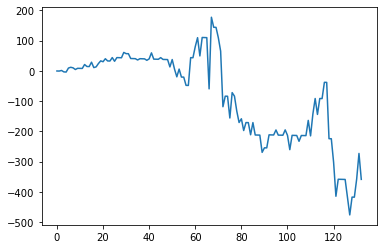

In [95]:
df_weighted_sell = weighted_mid_algo(df,'s')

Weighted_mid algo sells 3970.2619594177936 shares of SH and 2774.072283664472 shares of SDS for a total used cash $ 109000 and total pnl $ -284.368097002618
Average trade price for SH is $ 18.391712328767127
Average trade price for SDS is $ 12.982361111111109
Sum of Avg_price * inventory for SH+SDS is $ -109033.92396231618


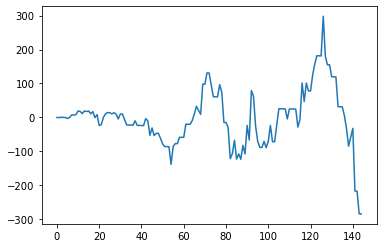

In [96]:
df_weighted_test_sell = weighted_mid_algo(df_test,'s')

Micro algo sells 3622.3910765693627 shares of SH and 2518.992962776745 shares of SDS for a total used cash $ 100000 and total pnl $ -353.94081842454034
Average trade price for SH is $ 18.501119402985086
Average trade price for SDS is $ 13.105606060606057
Sum of Avg_price * inventory for SH+SDS is $ -100031.2192715084


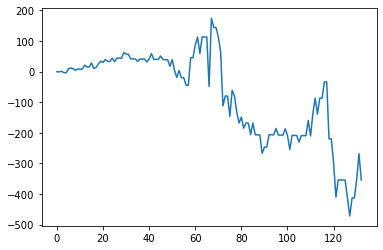

In [97]:
df_micro_sell=micro_algo(df,state_table,'s')

Micro algo sells 3970.883247065606 shares of SH and 2773.092180461481 shares of SDS for a total used cash $ 109000 and total pnl $ -283.0494776946143
Average trade price for SH is $ 18.38883561643836
Average trade price for SDS is $ 12.986944444444443
Sum of Avg_price * inventory for SH+SDS is $ -109033.91336933497


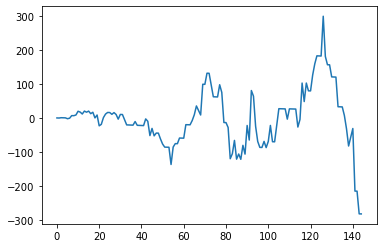

In [98]:
df_micro_test_sell=micro_algo(df_test,state_table,'s')

## Find the states where different executions between weighted-mid algo and micro algo happen

In [99]:
traded_asset_sell=pd.concat([df_random_sell.random_which_asset,df_weighted_sell.weighted_which_asset,df_micro_sell.micro_which_asset,df_micro_sell.current_state],axis=1)
traded_asset_sell[traded_asset_sell.weighted_which_asset!=traded_asset_sell.micro_which_asset]

,random_which_asset,weighted_which_asset,micro_which_asset,current_state
time,,,,
2020-12-02 15:05:00+00:00,SH,SDS,SH,311
2020-12-02 15:30:00+00:00,SH,SH,SDS,211
2020-12-02 15:35:00+00:00,SDS,SH,SDS,211
2020-12-02 15:45:00+00:00,SH,SH,SDS,212
2020-12-02 16:55:00+00:00,SDS,SH,SDS,200
2020-12-02 17:00:00+00:00,SH,SH,SDS,211
2020-12-02 17:05:00+00:00,SH,SH,SDS,201
2020-12-02 17:20:00+00:00,SDS,SH,SDS,211
2020-12-02 17:25:00+00:00,SDS,SH,SDS,211


In [100]:
traded_asset_test_sell=pd.concat([df_random_test_sell.random_which_asset,df_weighted_test_sell.weighted_which_asset,df_micro_test_sell.micro_which_asset,df_micro_test_sell.current_state],axis=1)
traded_asset_test_sell[traded_asset_test_sell.weighted_which_asset!=traded_asset_test_sell.micro_which_asset]

,random_which_asset,weighted_which_asset,micro_which_asset,current_state
time,,,,
2020-12-03 14:55:00+00:00,SH,SH,SDS,212
2020-12-03 15:00:00+00:00,SH,SH,SDS,211
2020-12-03 15:05:00+00:00,SH,SH,SDS,211
2020-12-03 15:45:00+00:00,SH,SH,SDS,212
2020-12-03 16:15:00+00:00,SDS,SDS,SH,300
2020-12-03 16:25:00+00:00,SH,SH,SDS,211
2020-12-03 18:15:00+00:00,SH,SDS,SH,311
2020-12-03 18:25:00+00:00,SDS,SH,SDS,211
2020-12-03 20:40:00+00:00,SDS,SDS,SH,311


C:\Users\Anne Shen\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


American snipper algo (abs diff) sells 3622.3910765693627 shares of SH and 2518.992962776745 shares of SDS for a total used cash $ 100000 and total pnl $ -353.94081842454034
Average trade price for SH is $ 18.501119402985083
Average trade price for SDS is $ 13.105606060606057
Sum of Avg_price * inventory for SH+SDS is $ -100031.21927150837
American snipper algo (abs diff) sells 3970.883247065606 shares of SH and 2773.092180461481 shares of SDS for a total used cash $ 109000 and total pnl $ -283.0494776946143
Average trade price for SH is $ 18.38883561643836
Average trade price for SDS is $ 12.986944444444443
Sum of Avg_price * inventory for SH+SDS is $ -109033.91336933497
American snipper algo (abs diff) sells 3622.3910765693627 shares of SH and 2518.992962776745 shares of SDS for a total used cash $ 100000 and total pnl $ -353.94081842454034
Average trade price for SH is $ 18.501119402985083
Average trade price for SDS is $ 13.105606060606057
Sum of Avg_price * inventory for SH+SDS is

American snipper algo (abs diff) sells 3970.7646489541203 shares of SH and 2772.646171709616 shares of SDS for a total used cash $ 109000 and total pnl $ -179.894473573695
Average trade price for SH is $ 18.38938356164384
Average trade price for SDS is $ 12.989027777777777
Sum of Avg_price * inventory for SH+SDS is $ -109033.89230491879
American snipper algo (abs diff) sells 3785.7825070482368 shares of SH and 2402.5122932496115 shares of SDS for a total used cash $ 101500 and total pnl $ -322.5782317027224
Average trade price for SH is $ 18.49528571428572
Average trade price for SDS is $ 13.116428571428573
Sum of Avg_price * inventory for SH+SDS is $ -101531.51000638962
American snipper algo (abs diff) sells 3970.7646489541203 shares of SH and 2772.646171709616 shares of SDS for a total used cash $ 109000 and total pnl $ -179.894473573695
Average trade price for SH is $ 18.38938356164384
Average trade price for SDS is $ 12.989027777777777
Sum of Avg_price * inventory for SH+SDS is $ -

American snipper algo (abs diff) sells 3514.1069025898055 shares of SH and 2557.0182758389574 shares of SDS for a total used cash $ 98500 and total pnl $ -261.975971896034
Average trade price for SH is $ 18.501923076923084
Average trade price for SDS is $ 13.10634328358209
Sum of Avg_price * inventory for SH+SDS is $ -98530.8949013396
American snipper algo (abs diff) sells 3916.74241954892 shares of SH and 2772.587831232606 shares of SDS for a total used cash $ 108000 and total pnl $ -278.9355819935736
Average trade price for SH is $ 18.387638888888894
Average trade price for SDS is $ 12.989305555555553
Sum of Avg_price * inventory for SH+SDS is $ -108033.63575095392
American snipper algo (abs diff) sells 3514.1069025898055 shares of SH and 2557.0182758389574 shares of SDS for a total used cash $ 98500 and total pnl $ -261.975971896034
Average trade price for SH is $ 18.501923076923084
Average trade price for SDS is $ 13.10634328358209
Sum of Avg_price * inventory for SH+SDS is $ -9853

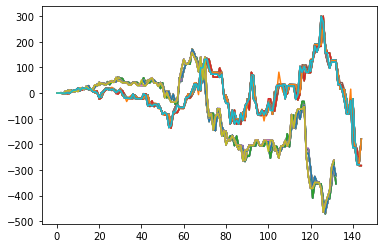

In [101]:
# American Sniper with different thresholds
traded_time_train_sell=[]
traded_time_test_sell=[]
for i in range(30):
    traded_time_train_sell.append(american_sniper_algo_absDiff_constant(df,state_table,i,len(df_micro),buy_or_sell='s'))
    traded_time_test_sell.append(american_sniper_algo_absDiff_constant(df_test,state_table,i,len(df_micro_test),buy_or_sell='s'))

# Results

In [102]:
result_table=pd.DataFrame(results,columns=['buy_or_sell','algo','P_SH','Q_SH','P_SDS','Q_SDS','PNL'])
result_table['train_or_test']=['train','test']*(len(result_table)//2)
result_table

,buy_or_sell,algo,P_SH,Q_SH,P_SDS,Q_SDS,PNL,train_or_test
0,b,1. random algo,18.486,"3,623.301",13.123,"2,513.817",302.557,train
1,b,1. random algo,18.392,"3,968.015",12.978,"2,772.944",228.278,test
2,b,2. weighted mid algo,18.491,"3,514.196",13.114,"2,591.697",307.148,train
3,b,2. weighted mid algo,18.389,"3,914.406",12.978,"2,811.347",240.726,test
4,b,3. micro algo,18.476,"3,571.321",13.134,"2,549.667",311.796,train
...,...,...,...,...,...,...,...,...
127,s,4. American sniper algo_27,18.388,"-3,916.742",12.989,"-2,772.588",-278.936,test
128,s,4. American sniper algo_28,18.502,"-3,514.107",13.106,"-2,557.018",-261.976,train
129,s,4. American sniper algo_28,18.388,"-3,916.742",12.989,"-2,772.588",-278.936,test
130,s,4. American sniper algo_29,18.500,"-3,514.487",13.109,"-2,556.495",-262.136,train


In [103]:
multi=result_table.set_index(['buy_or_sell', 'algo','train_or_test'])
multi

P_SH       Q_SH  P_SDS  \
buy_or_sell algo                       train_or_test                            
b           1. random algo             train         18.486  3,623.301 13.123   
                                       test          18.392  3,968.015 12.978   
            2. weighted mid algo       train         18.491  3,514.196 13.114   
                                       test          18.389  3,914.406 12.978   
            3. micro algo              train         18.476  3,571.321 13.134   
...                                                     ...        ...    ...   
s           4. American sniper algo_27 test          18.388 -3,916.742 12.989   
            4. American sniper algo_28 train         18.502 -3,514.107 13.106   
                                       test          18.388 -3,916.742 12.989   
            4. American sniper algo_29 train         18.500 -3,514.487 13.109   
                                       test          18.388 -3,916.624 12.988   

                                                          Q_SDS      PNL  
buy_or_sell algo                       train_or_test                      
b           1. random algo             train          2,513.817  302.557  
                                       test           2,772.944  228.278  
            2. weighted mid algo       train          2,591.697  307.148  
                                       test           2,811.347  240.726  
            3. micro algo              train          2,549.667  311.796  
...                                                         ...      ...  
s           4. American sniper algo_27 test          -2,772.588 -278.936  
            4. American sniper algo_28 train         -2,557.018 -261.976  
                                       test          -2,772.588 -278.936  
            4. American sniper algo_29 train         -2,556.495 -262.136  
                                       test          -2,772.825 -279.852  

[132 rows x 5 columns]

In [104]:
pd.options.display.float_format = '{:,.3f}'.format
multi.groupby(level=[2,1])[['Q_SH','Q_SDS','PNL']].sum()

Q_SH   Q_SDS     PNL
train_or_test algo                                              
test          1. random algo              -2.158  -2.138 -67.604
              2. weighted mid algo       -55.856  37.275 -43.642
              3. micro algo              -57.098  39.233 -41.012
              4. American sniper algo_00 -57.098  39.233 -41.012
              4. American sniper algo_01 -57.098  39.233 -41.012
...                                          ...     ...     ...
train         4. American sniper algo_25 111.767 -82.935 -21.363
              4. American sniper algo_26 111.767 -82.935 -21.363
              4. American sniper algo_27 111.767 -82.935 -21.363
              4. American sniper algo_28 111.767 -82.935 -21.363
              4. American sniper algo_29 111.006 -81.889 -21.682

[66 rows x 3 columns]

In [108]:
x=multi.groupby(level=[2,1])[['Q_SH','Q_SDS','PNL']].sum()
# x.to_csv('Results_Dec2Dec3.csv')

# PNL comparison for train and test using different constraints

In [105]:
y=result_table.set_index(['train_or_test','algo','buy_or_sell'])
z=y.groupby(level=[0,1])[['Q_SH','Q_SDS','PNL']].sum()

In [106]:
z.loc['train']

,Q_SH,Q_SDS,PNL
algo,,,
1. random algo,-1.961,-1.916,-61.606
2. weighted mid algo,-165.352,114.768,-51.582
3. micro algo,-51.070,30.674,-42.145
4. American sniper algo_00,-51.070,30.674,-42.145
4. American sniper algo_01,-51.070,30.674,-42.145
4. American sniper algo_02,-51.070,30.674,-42.145
4. American sniper algo_03,-51.070,30.674,-42.145
4. American sniper algo_04,-51.070,30.674,-42.145
4. American sniper algo_05,-51.070,30.674,-42.145


In [107]:
z.loc['test']

,Q_SH,Q_SDS,PNL
algo,,,
1. random algo,-2.158,-2.138,-67.604
2. weighted mid algo,-55.856,37.275,-43.642
3. micro algo,-57.098,39.233,-41.012
4. American sniper algo_00,-57.098,39.233,-41.012
4. American sniper algo_01,-57.098,39.233,-41.012
4. American sniper algo_02,-57.098,39.233,-41.012
4. American sniper algo_03,-57.098,39.233,-41.012
4. American sniper algo_04,-57.098,39.233,-41.012
4. American sniper algo_05,-57.098,39.233,-41.012


In [109]:
###################################### depends on the constant threshold ##################################################
result=pd.concat([z.loc['train'].iloc[:3],z.loc['train'].iloc[[23]],z.loc['test'].iloc[:3],z.loc['test'].iloc[[23]]])
result['train_or_test']=['train']*4+['test']*4
result

,Q_SH,Q_SDS,PNL,train_or_test
algo,,,,
1. random algo,-1.961,-1.916,-61.606,train
2. weighted mid algo,-165.352,114.768,-51.582,train
3. micro algo,-51.070,30.674,-42.145,train
4. American sniper algo_20,-268.339,185.812,-25.586,train
1. random algo,-2.158,-2.138,-67.604,test
2. weighted mid algo,-55.856,37.275,-43.642,test
3. micro algo,-57.098,39.233,-41.012,test
4. American sniper algo_20,-56.743,40.005,-24.656,test


In [114]:
result.to_csv('Results_Dec2Dec3.csv')

# Execution time (early execution proportion)

In [110]:
algo_names=z.loc['train'].index[3:]

# executing time of every period if we cut the period to 30 buckets
df_traded_time_train_buy=pd.DataFrame(map(list, zip(*traded_time_train_buy)),columns=algo_names)
df_traded_time_train_buy

algo,4. American sniper algo_00,4. American sniper algo_01,4. American sniper algo_02,4. American sniper algo_03,4. American sniper algo_04,4. American sniper algo_05,4. American sniper algo_06,4. American sniper algo_07,4. American sniper algo_08,4. American sniper algo_09,...,4. American sniper algo_20,4. American sniper algo_21,4. American sniper algo_22,4. American sniper algo_23,4. American sniper algo_24,4. American sniper algo_25,4. American sniper algo_26,4. American sniper algo_27,4. American sniper algo_28,4. American sniper algo_29
0,early,early,early,early,early,early,early,early,early,early,...,early,early,early,early,early,early,early,early,early,early
1,early,early,early,early,early,early,early,early,early,early,...,early,early,early,early,early,early,early,early,early,end_of_5_min
2,early,early,early,early,early,early,early,early,early,early,...,early,end_of_5_min,end_of_5_min,end_of_5_min,end_of_5_min,end_of_5_min,end_of_5_min,end_of_5_min,end_of_5_min,end_of_5_min
3,early,early,early,early,early,early,early,early,early,early,...,early,early,early,early,early,early,early,early,early,early
4,early,early,early,early,early,early,early,early,early,early,...,early,early,early,early,early,early,early,early,early,early
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,early,early,early,early,early,early,early,early,early,early,...,early,end_of_5_min,end_of_5_min,end_of_5_min,end_of_5_min,end_of_5_min,end_of_5_min,end_of_5_min,end_of_5_min,end_of_5_min
128,early,early,early,early,early,early,early,early,early,early,...,early,end_of_5_min,end_of_5_min,end_of_5_min,end_of_5_min,end_of_5_min,end_of_5_min,end_of_5_min,end_of_5_min,end_of_5_min
129,early,early,early,early,early,early,early,early,early,early,...,early,early,early,early,early,early,early,early,early,early
130,early,early,early,early,early,early,early,early,early,early,...,early,end_of_5_min,end_of_5_min,end_of_5_min,end_of_5_min,end_of_5_min,end_of_5_min,end_of_5_min,end_of_5_min,end_of_5_min


In [111]:
df_traded_time_train_sell=pd.DataFrame(map(list, zip(*traded_time_train_sell)),columns=algo_names)
df_traded_time_test_buy=pd.DataFrame(map(list, zip(*traded_time_test_buy)),columns=algo_names)
df_traded_time_test_sell=pd.DataFrame(map(list, zip(*traded_time_test_sell)),columns=algo_names)

In [116]:
# Execution time in each period
execute_time_train_buy=df_traded_time_train_buy.apply(pd.value_counts).fillna(0).astype('int32')
execute_time_train_buy

algo,4. American sniper algo_00,4. American sniper algo_01,4. American sniper algo_02,4. American sniper algo_03,4. American sniper algo_04,4. American sniper algo_05,4. American sniper algo_06,4. American sniper algo_07,4. American sniper algo_08,4. American sniper algo_09,...,4. American sniper algo_20,4. American sniper algo_21,4. American sniper algo_22,4. American sniper algo_23,4. American sniper algo_24,4. American sniper algo_25,4. American sniper algo_26,4. American sniper algo_27,4. American sniper algo_28,4. American sniper algo_29
early,132,132,132,132,132,132,132,112,106,106,...,94,62,62,62,62,62,62,62,62,58
end_of_5_min,0,0,0,0,0,0,0,20,26,26,...,38,70,70,70,70,70,70,70,70,74


In [125]:
# proportion of executing early (not at the end of 5 minutes)
execute_time_train_buy.loc['early']/len(df_traded_time_train_buy)*100

algo
4. American sniper algo_00   100.000
4. American sniper algo_01   100.000
4. American sniper algo_02   100.000
4. American sniper algo_03   100.000
4. American sniper algo_04   100.000
4. American sniper algo_05   100.000
4. American sniper algo_06   100.000
4. American sniper algo_07    84.848
4. American sniper algo_08    80.303
4. American sniper algo_09    80.303
4. American sniper algo_10    80.303
4. American sniper algo_11    80.303
4. American sniper algo_12    80.303
4. American sniper algo_13    80.303
4. American sniper algo_14    80.303
4. American sniper algo_15    80.303
4. American sniper algo_16    80.303
4. American sniper algo_17    80.303
4. American sniper algo_18    80.303
4. American sniper algo_19    80.303
4. American sniper algo_20    71.212
4. American sniper algo_21    46.970
4. American sniper algo_22    46.970
4. American sniper algo_23    46.970
4. American sniper algo_24    46.970
4. American sniper algo_25    46.970
4. American sniper algo_26    46.

In [124]:
# proportion of executing early (not at the end of 5 minutes)
execute_time_train_sell=df_traded_time_train_sell.apply(pd.value_counts).fillna(0).astype('int32')
execute_time_train_sell.loc['early']/len(df_traded_time_train_sell)*100

algo
4. American sniper algo_00   100.000
4. American sniper algo_01   100.000
4. American sniper algo_02   100.000
4. American sniper algo_03   100.000
4. American sniper algo_04   100.000
4. American sniper algo_05   100.000
4. American sniper algo_06   100.000
4. American sniper algo_07    84.848
4. American sniper algo_08    80.303
4. American sniper algo_09    80.303
4. American sniper algo_10    80.303
4. American sniper algo_11    80.303
4. American sniper algo_12    80.303
4. American sniper algo_13    80.303
4. American sniper algo_14    80.303
4. American sniper algo_15    80.303
4. American sniper algo_16    80.303
4. American sniper algo_17    80.303
4. American sniper algo_18    80.303
4. American sniper algo_19    80.303
4. American sniper algo_20    71.212
4. American sniper algo_21    46.970
4. American sniper algo_22    46.970
4. American sniper algo_23    46.970
4. American sniper algo_24    46.970
4. American sniper algo_25    46.970
4. American sniper algo_26    46.

In [123]:
# proportion of executing early (not at the end of 5 minutes)
execute_time_test_buy=df_traded_time_test_buy.apply(pd.value_counts).fillna(0).astype('int32')
execute_time_test_buy.loc['early']/len(df_traded_time_test_buy)*100

algo
4. American sniper algo_00   100.000
4. American sniper algo_01   100.000
4. American sniper algo_02   100.000
4. American sniper algo_03   100.000
4. American sniper algo_04   100.000
4. American sniper algo_05   100.000
4. American sniper algo_06   100.000
4. American sniper algo_07    92.361
4. American sniper algo_08    89.583
4. American sniper algo_09    89.583
4. American sniper algo_10    89.583
4. American sniper algo_11    89.583
4. American sniper algo_12    89.583
4. American sniper algo_13    89.583
4. American sniper algo_14    89.583
4. American sniper algo_15    89.583
4. American sniper algo_16    89.583
4. American sniper algo_17    89.583
4. American sniper algo_18    89.583
4. American sniper algo_19    89.583
4. American sniper algo_20    75.694
4. American sniper algo_21    29.167
4. American sniper algo_22    29.167
4. American sniper algo_23    29.167
4. American sniper algo_24    29.167
4. American sniper algo_25    29.167
4. American sniper algo_26    29.

In [127]:
# proportion of executing early (not at the end of 5 minutes)
execute_time_test_sell=df_traded_time_test_sell.apply(pd.value_counts).fillna(0).astype('int32')
execute_time_test_sell.loc['early']/len(df_traded_time_test_sell)*100

algo
4. American sniper algo_00   100.000
4. American sniper algo_01   100.000
4. American sniper algo_02   100.000
4. American sniper algo_03   100.000
4. American sniper algo_04   100.000
4. American sniper algo_05   100.000
4. American sniper algo_06   100.000
4. American sniper algo_07    92.361
4. American sniper algo_08    89.583
4. American sniper algo_09    89.583
4. American sniper algo_10    89.583
4. American sniper algo_11    89.583
4. American sniper algo_12    89.583
4. American sniper algo_13    89.583
4. American sniper algo_14    89.583
4. American sniper algo_15    89.583
4. American sniper algo_16    89.583
4. American sniper algo_17    89.583
4. American sniper algo_18    89.583
4. American sniper algo_19    89.583
4. American sniper algo_20    75.694
4. American sniper algo_21    29.167
4. American sniper algo_22    29.167
4. American sniper algo_23    29.167
4. American sniper algo_24    29.167
4. American sniper algo_25    29.167
4. American sniper algo_26    29.